In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_ivp

from scipy.optimize import lsq_linear

import iisignature
from ripser import ripser
from persim import plot_diagrams


In [2]:

params = {
    'm1': 10,     # pendulum mass
    'm2': 10,
    'l': 3,     # pendulum length
    'g': 9.81,    # gravity
    'M': 10000.0,     # beam mass
    'J': 0.4,     # pendulum rotational inertia
    'b': 0.1,    # damping coefficient
    'k': 0.5 #coupling stiffness between pendulums
}


In [3]:
def sensor_model(x_true, number_variables):
    noise = np.random.normal(0, 0.05, size=number_variables)
    return x_true + noise  

In [4]:
def huygens_nonlinear_dynamics(t, y, params, u, disturbance_func_con=False, feedback=None, dt=None,
                               angle_limits=None, accel_bounds=None):
    """
    Computes the nonlinear dynamics of two pendulums mounted on a shared movable beam.

    Parameters:
    - t: time
    - y: state vector [theta1, omega1, theta2, omega2, x, v]
    - params: dictionary of physical parameters
    - u: control torque applied to pendulum 1 (scalar already evaluated outside)
    - disturbance_func_con: bool, include forcing_disturbance
    - feedback: optional feedback term for disturbance
    - dt: timestep (unused here but kept for interface compatibility)
    - angle_limits: None, tuple (min,max) applied to both thetas, or dict {'lower': [...], 'upper': [...]} length 2
    - accel_bounds: None or tuple (lower_vec, upper_vec) each length 3 for (alpha1, alpha2, a_x)

    Returns list dydt: [dtheta1, domega1, dtheta2, domega2, dx, dv]
    """
    # Unpack state variables
    theta1, omega1, theta2, omega2, x, v = y

    # Optionally clip angles (position saturation)
    if angle_limits is not None:
        if isinstance(angle_limits, dict):
            lower_angles = np.asarray(angle_limits['lower'], dtype=float)
            upper_angles = np.asarray(angle_limits['upper'], dtype=float)
            if lower_angles.shape[0] != 2 or upper_angles.shape[0] != 2:
                raise ValueError("angle_limits dict must supply exactly two bounds for theta1 and theta2")
        else:  # assume (min,max)
            lower_angles = np.array([angle_limits[0], angle_limits[0]], dtype=float)
            upper_angles = np.array([angle_limits[1], angle_limits[1]], dtype=float)
        if np.any(lower_angles > upper_angles):
            raise ValueError("angle_limits invalid: a lower bound exceeds its upper bound")
        theta1 = float(np.clip(theta1, lower_angles[0], upper_angles[0]))
        theta2 = float(np.clip(theta2, lower_angles[1], upper_angles[1]))

    # Unpack parameters
    m1 = params['m1']      # mass of each pendulum
    m2 = params['m2']      # mass of each pendulum
    l = params['l']      # length of each pendulum
    g = params['g']      # gravitational acceleration
    M = params['M']      # mass of the beam
    J = params['J']      # rotational inertia of each pendulum
    b = params['b']      # damping coefficient
    k = params['k']      # coupling stiffness between pendulums

    # Control torque and external force
    tau1 = u*m2
    tau2 = -u*m1  # original heuristic relation
    f = forcing_disturbance(t, feedback) if disturbance_func_con else 0.0

    # Mass matrix A and RHS vector b_vec
    A = np.array([
        [J + k, -k, -m2 * l * np.cos(theta1)],
        [-k, J + k+b, -m1 * l * np.cos(theta2)],
        [-m1 * l * np.cos(theta1), -m2 * l * np.cos(theta2), M + m1 +m2]
    ])

    b_vec = np.array([
        -b * omega1 - m1 * g * l * np.sin(theta1) + tau1+f,
        -b * omega2 - m2 * g * l * np.sin(theta2) + tau2-f,
        f + m1 * l * omega1**2 * np.sin(theta1) + m2 * l * omega2**2 * np.sin(theta2)
    ])


    lower_bounds = np.array([-1000.0, -1000.0, -100.0], dtype=float)
    upper_bounds = np.array([ 1000.0,  1000.0,  100.0], dtype=float)

    result = lsq_linear(A, b_vec, bounds=(lower_bounds, upper_bounds))
    alpha1, alpha2, a_x = result.x
    return [omega1, alpha1, omega2, alpha2, v, a_x]

In [5]:
def forcing_disturbance(t,feedback=None):
    if feedback == None:
        feedback=1
    return -feedback* np.cos(0.1 * t+np.deg2rad(20)) + np.clip(np.exp(np.random.normal(30, 0.05)), -0.4, 0.4)

In [6]:
class EKFObserver:
    def __init__(self, Q, R, number_state_variables):
        # Ensure float dtype so in-place additions with float deltas don't raise a UFuncTypeError
        self.x_hat = np.ones(number_state_variables, dtype=float)  # initial state estimate (float)
        self.P = np.eye(number_state_variables, dtype=float)        # initial covariance
        self.Q = Q.astype(float)               # process noise covariance
        self.R = R.astype(float)               # measurement noise covariance
        self.last_K = np.zeros((number_state_variables,number_state_variables), dtype=float)  # will hold most recent Kalman gain
        self.number_state_variables=number_state_variables

    def predict(self, u, dt):
        f = huygens_nonlinear_dynamics(0, self.x_hat, params, u)  # no disturbance in prediction
        # f returns a list of floats; in-place add is now safe because x_hat is float
        self.x_hat += np.array(f, dtype=float) * dt
        self.P += self.Q * dt

    def update(self, y):       
        y = np.asarray(y, dtype=float).reshape(-1)
        H = np.eye(self.number_state_variables)
        y_hat = self.x_hat
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x_hat += K @ (y - y_hat)
        self.P = (np.eye(self.number_state_variables) - K @ H) @ self.P
        self.last_K = K


    def step(self, u, y, dt):
        self.predict(u, dt)
        self.update(y)
        return self.x_hat

In [7]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.integral = 0.0
        self.prev_error = 0.0
        self.integral_history=[]
        self.error_history=[]
        self.derivative_history=[]

    def compute(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        self.prev_error = error
        # record histories
        self.error_history.append(error)
        self.integral_history.append(self.integral)
        self.derivative_history.append(derivative)
        return self.Kp * error + self.Ki * self.integral + self.Kd * derivative

In [8]:
y0 = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1]  # initial angles, velocities, beam position and velocity
T = 45
t_span = (0, T)   
times = np.linspace(*t_span, 2000) 
number_state_variables=len(y0)

x = np.array([0.1, 0.0], dtype=float)  # true initial state

# Histories
x_history = [x.copy()]        # true state trajectory
x_hat_history = []             # observer estimates
u_history = []                 # control inputs
error_history = []             # tracking errors
sensor_history = []            # noisy measurements
dx_history = []                # state derivatives
K_history = []                 # Kalman gains
P_history = []                 # Covariance matrices
Q_history = []                 # Process noise matrices
R_history = []                 # Measurement noise matrices
pid_integral_history = []      # integral term
pid_derivative_history = []    # derivative term (mirrors controller history)
forcing_history = []           # disturbance values d(t)

# Components
ekf = EKFObserver(Q=np.eye(number_state_variables)*0.01, R=np.eye(number_state_variables)*0.05,number_state_variables=number_state_variables)
pid = PIDController(Kp=10, Ki=1, Kd=2)

# Reference / initial control
desired_theta = np.deg2rad(10.0)
u = 0.0  # control applied over first interval

In [9]:
# Initialization
y = y0.copy()  # Initial state: [theta1, omega1, theta2, omega2, x_beam, v_beam]
dt = times[1] - times[0]  # Time step size
# Angle limits (same for both angles here); can also pass dict for per-angle
theta_limits = (-np.deg2rad(30), np.deg2rad(30))

# Histories
y_history = [y.copy()]
y_hat_history = []
u_history = []
error_history = []
sensor_history = []
forcing_history = []
dy_history = []

for k, t in enumerate(times):
    # 1. Propagate system with control u using precomputed acceleration bounds
    dy = huygens_nonlinear_dynamics(t, y, params, u, disturbance_func_con=True,feedback=y[0], dt=dt,
                                    angle_limits=theta_limits)
    d_val = forcing_disturbance(t,feedback=y[0])
    # Debug prints (optional - comment out for performance)
    # print("d_val", d_val)
    # print("dy", dy)

    # Euler integration
    y += np.array(dy) * dt
    #y[0]=np.clip(y[0], -np.deg2rad(30), np.deg2rad(30))
    #y[2]=np.clip(y[2], -np.deg2rad(100), np.deg2rad(100))
    y[4]=np.clip(y[4], -100, 100)

    # 2. Measurement
    measurement = (sensor_model(y, number_state_variables))
    y_hat = measurement

    # 3. EKF step
    #y_hat = ekf.step(u=u, y=measurement, dt=dt)

    # 4. Control law
    #error = desired_theta - y_hat[0]  # theta1 control objective
    #u_next = pid.compute(error, dt)
    #u_next = np.clip(u_next, -6000, 6000)  # control saturation

    # 5. Log histories
    dy_history.append(dy)
    y_history.append(y.copy())
    forcing_history.append(d_val)
    #y_hat_history.append(y_hat.copy())
    #u_history.append(u)
    #error_history.append(error)
    #sensor_history.append(measurement.copy())

    # EKF internals
    #K_history.append(ekf.last_K.copy())
    #P_history.append(ekf.P.copy())
    #Q_history.append(ekf.Q.copy())
    #R_history.append(ekf.R.copy())

    # PID internals
    #pid_integral_history.append(pid.integral)
    #pid_derivative_history.append(pid.derivative_history[-1])

    # 6. Advance control
    #u = u_next

Text(0, 0.5, 'N')

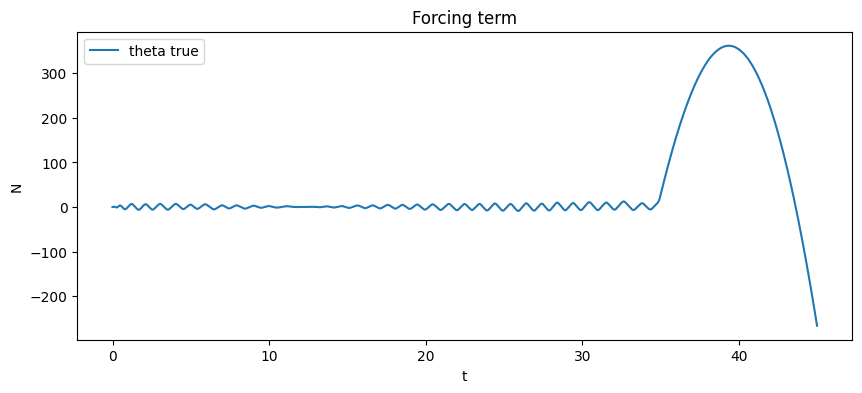

In [10]:
# Plot theta (true vs estimate)
plt.figure(figsize=(10,4))
plt.plot(times, forcing_history, label='theta true')
#plt.xlim(20,100)
#plt.ylim(9.5,10.5)
plt.legend(); plt.title('Forcing term')
plt.xlabel('t'); plt.ylabel('N')

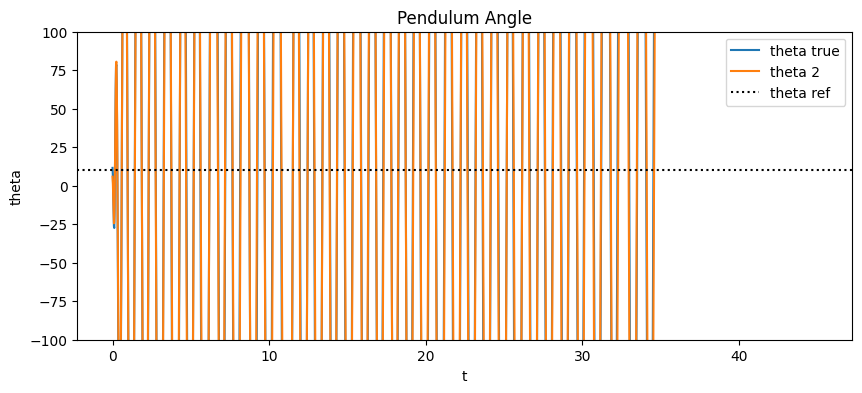

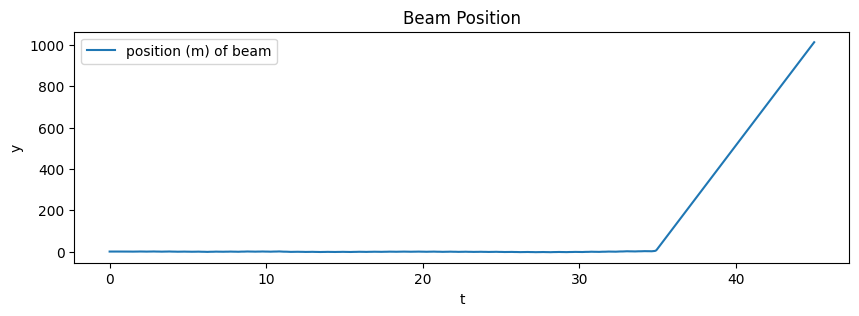

In [11]:
# Plot theta (true vs estimate)
plt.figure(figsize=(10,4))
plt.plot(times, [np.rad2deg(x[0]) for x in y_history[1:]], label='theta true')
plt.plot(times, [np.rad2deg(x[2]) for x in y_history[1:]], label='theta 2')
#plt.plot(times, [xh[0] for xh in y_hat_history], '--', label='theta est')
plt.axhline(np.rad2deg(desired_theta), color='k', linestyle=':', label='theta ref')
#plt.xlim(20,100)
plt.ylim(-100,100)
plt.legend(); plt.title('Pendulum Angle')
plt.xlabel('t'); plt.ylabel('theta')

# Control input
#plt.figure(figsize=(10,3))
#plt.plot(times, u_history, label='u (torque)')
#plt.xlim(20,100)
#plt.ylim(-20,20)
#plt.xlabel('t'); plt.ylabel('u'); plt.title('Control Torque'); plt.legend()

plt.figure(figsize=(10,3))
plt.plot(times, [x[5] for x in y_history[1:]], label='position (m) of beam')
#plt.xlim(20,100)
#plt.ylim(-20,20)
plt.xlabel('t'); plt.ylabel('y'); plt.title('Beam Position'); plt.legend()

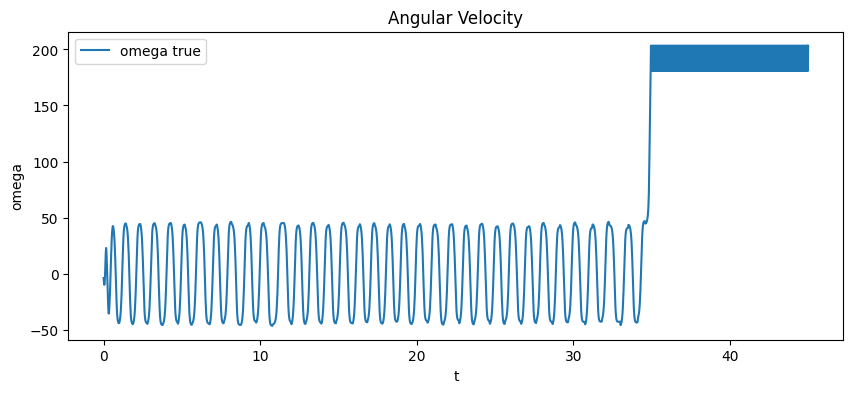

In [12]:
plt.figure(figsize=(10,4))
plt.plot(times, [x[1] for x in y_history[1:]], label='omega true')
#plt.plot(times, [xh[1] for xh in y_hat_history], '--', label='omega est')
#plt.xlim(15,500)
#plt.ylim(-1,1)
plt.xlabel('t'); plt.ylabel('omega'); plt.title('Angular Velocity'); plt.legend()

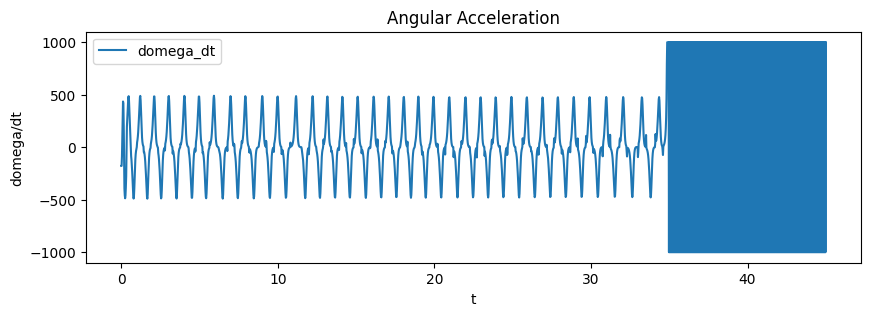

In [13]:
plt.figure(figsize=(10,3))
plt.plot(times, [dx[1] for dx in dy_history], label='domega_dt')
#plt.xlim(20,100)
#plt.ylim(-3,3)
plt.xlabel('t'); plt.ylabel('domega/dt'); plt.title('Angular Acceleration'); plt.legend()

In [14]:
# Assemble selected histories (dynamics states & derivatives, sensor, forcing, error, PID terms)

# Number of simulated steps (derivative entries)
n_steps = len(dy_history)

# Align state history (skip initial to match derivative count)
state_slice = y_history[1:1+n_steps]

# Extract state components
theta1 = [s[0] for s in state_slice]
omega1 = [s[1] for s in state_slice]
theta2 = [s[2] for s in state_slice]
omega2 = [s[3] for s in state_slice]
x_beam = [s[4] for s in state_slice]
v_beam = [s[5] for s in state_slice]

# Derivatives mapping from dy = [omega1, alpha1, omega2, alpha2, v, a_x]
domega1 = [d[1] for d in dy_history]
domega2 = [d[3] for d in dy_history]
dv = [d[5] for d in dy_history]

# Sensor measurements (same ordering as state)
sensor_theta1 = [m[0] for m in sensor_history]
sensor_omega1 = [m[1] for m in sensor_history]
sensor_theta2 = [m[2] for m in sensor_history]
sensor_omega2 = [m[3] for m in sensor_history]
sensor_x = [m[4] for m in sensor_history]
sensor_v = [m[5] for m in sensor_history]

# Time vector aligned to steps
t_vec = times[:n_steps]

# Ensure auxiliary histories align (truncate or pad if needed)
def align(lst, target):
    if len(lst) == target:
        return lst
    if len(lst) > target:
        return lst[:target]
    return lst + [np.nan]*(target-len(lst))

forcing_aligned = align(forcing_history, n_steps)
error_aligned = align(error_history, n_steps)
pid_int_aligned = align(pid_integral_history, n_steps)
pid_der_aligned = align(pid_derivative_history, n_steps)

cols = {
    't': t_vec,
    # States
    'theta1': theta1,
    'omega1': omega1,
    'theta2': theta2,
    'omega2': omega2,
    'x_beam': x_beam,
    'v_beam': v_beam,
    # Derivatives
    'domega1': domega1,
    'domega2': domega2,
    'dv': dv,
    # Sensors
    'sensor_theta1': sensor_theta1,
    'sensor_omega1': sensor_omega1,
    'sensor_theta2': sensor_theta2,
    'sensor_omega2': sensor_omega2,
    'sensor_x': sensor_x,
    'sensor_v': sensor_v,
    # Forcing & control performance
    'forcing': forcing_aligned,
    'error': error_aligned,
    'pid_integral': pid_int_aligned,
    'pid_derivative': pid_der_aligned,
}

# Build DataFrame
max_len = max(len(v) for v in cols.values())
for k, v in list(cols.items()):
    if len(v) < max_len:
        cols[k] = align(v, max_len)

df = pd.DataFrame(cols)

csv_path = 'data/data_pendulum/simulation_histories_core.csv'
df.to_csv(csv_path, index=False)
print(f'Saved core histories to {csv_path} with shape {df.shape} and columns: {list(df.columns)}')

Saved core histories to data/data_pendulum/simulation_histories_core.csv with shape (2000, 20) and columns: ['t', 'theta1', 'omega1', 'theta2', 'omega2', 'x_beam', 'v_beam', 'domega1', 'domega2', 'dv', 'sensor_theta1', 'sensor_omega1', 'sensor_theta2', 'sensor_omega2', 'sensor_x', 'sensor_v', 'forcing', 'error', 'pid_integral', 'pid_derivative']


In [10]:
import numpy as np
import plotly.graph_objects as go

# Constants
G = 0.9  # Gravitational constant
m = 1.0  # Mass of each body
dt = 0.01  # Time step
steps = 5000  # Number of steps

# Initial positions and velocities for figure-eight orbit (from Chenciner & Montgomery 2000)
r1 = np.array([0.97000436, -0.24308753])
r2 = -r1
r3 = np.array([0.0, 0.0])

v1 = np.array([0.4662036850, 0.4323657300])
#v2 = 1.03*v1 # stable dynamic
v2 = v1 # figure 8
v3 = -2 * v1

# Initialize arrays to store trajectories
r1_traj, r2_traj, r3_traj = [], [], []

# Function to compute acceleration due to gravity
def acceleration(r_i, r_j):
    diff = r_j - r_i
    return G * m * diff / np.linalg.norm(diff)**3

# Simulation loop
for _ in range(steps):
    # Store current positions
    r1_traj.append(r1.copy())
    r2_traj.append(r2.copy())
    r3_traj.append(r3.copy())

    # Compute accelerations
    a1 = acceleration(r1, r2) + acceleration(r1, r3)
    a2 = acceleration(r2, r1) + acceleration(r2, r3)
    a3 = acceleration(r3, r1) + acceleration(r3, r2)

    # Update velocities
    v1 += a1 * dt
    v2 += a2 * dt
    v3 += a3 * dt

    # Update positions
    r1 += v1 * dt
    r2 += v2 * dt
    r3 += v3 * dt

# Convert trajectories to numpy arrays
r1_traj = np.array(r1_traj)
r2_traj = np.array(r2_traj)
r3_traj = np.array(r3_traj)

# Create plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=r1_traj[:,0], y=r1_traj[:,1], mode='lines', name='Body 1'))
fig.add_trace(go.Scatter(x=r2_traj[:,0], y=r2_traj[:,1], mode='lines', name='Body 2'))
fig.add_trace(go.Scatter(x=r3_traj[:,0], y=r3_traj[:,1], mode='lines', name='Body 3'))
fig.update_layout(title='Figure-Eight Orbit of Three-Body Problem',
                  xaxis_title='X Position',
                  yaxis_title='Y Position',
                  showlegend=True)
#plt.axis("equal")

# Save plot
#fig.write_image("figure_eight_orbit.png")
#fig.write_json("figure_eight_orbit.json")



In [16]:
import os, pandas as pd

# Ensure trajectories from previous cell exist
assert 'r1_traj' in globals(), 'Run the three-body simulation cell first.'

# Time vector
time_vec = np.arange(len(r1_traj)) * dt

# Velocities via finite difference (gradient keeps same length)
v1_traj = np.gradient(r1_traj, dt, axis=0)
v2_traj = np.gradient(r2_traj, dt, axis=0)
v3_traj = np.gradient(r3_traj, dt, axis=0)

# Accelerations using force model for consistency with physics
a1_list, a2_list, a3_list = [], [], []
for i in range(len(r1_traj)):
    r1i, r2i, r3i = r1_traj[i], r2_traj[i], r3_traj[i]
    a1_list.append(acceleration(r1i, r2i) + acceleration(r1i, r3i))
    a2_list.append(acceleration(r2i, r1i) + acceleration(r2i, r3i))
    a3_list.append(acceleration(r3i, r1i) + acceleration(r3i, r2i))

a1_traj = np.array(a1_list)
a2_traj = np.array(a2_list)
a3_traj = np.array(a3_list)

# Build DataFrame with requested columns
data = {
    't': time_vec,
    'r1x': r1_traj[:,0], 'r2x': r2_traj[:,0], 'r3x': r3_traj[:,0],
    'v1x': v1_traj[:,0], 'v2x': v2_traj[:,0], 'v3x': v3_traj[:,0],
    'a1x': a1_traj[:,0], 'a2x': a2_traj[:,0], 'a3x': a3_traj[:,0],
    'r1y': r1_traj[:,1], 'r2y': r2_traj[:,1], 'r3y': r3_traj[:,1],
    'v1y': v1_traj[:,1], 'v2y': v2_traj[:,1], 'v3y': v3_traj[:,1],
    'a1y': a1_traj[:,1], 'a2y': a2_traj[:,1], 'a3y': a3_traj[:,1],
}

df_three_body = pd.DataFrame(data)

# Save
os.makedirs('data/data_three_body', exist_ok=True)
output_path = 'data/data_three_body/three_body_histories.csv'
df_three_body.to_csv(output_path, index=False)
print(f'Saved three-body histories to {output_path} with shape {df_three_body.shape}')

Saved three-body histories to data/data_three_body/three_body_histories.csv with shape (5000, 19)


In [17]:
def ModifiedSignatureGram(paths: np.ndarray, signature_level=4) -> np.ndarray:
    """
        Computes the modified kernel Gram matrix induced by the signature feature map between
        paths, e.g. trajectories
        For the sake of the method, paths are assumed to be piece-wise linear between sample points

    ARGS:
        paths: np.ndarray (#paths, #samples, #dimensions), path samples
            #dimensions specifies the dimensionality of the path's embedding space
            #samples specifies the number of samples the path sequence was 

        signature_level: int, determines the number of signature levels that are computed for the encoding
            signature_level=0: constant
            signature_level=1: does not any information about the path only relative seperation
            signature_level=2 and higher: does contain geometric information about the path

    VALS:
        modified_gram: np.ndarray (#paths, #paths)
    """
    sigs = np.array(
        [iisignature.sig(p, signature_level) for p in paths]
    )
    sigs /= np.linalg.norm(sigs, axis=1)[:, None] # normalising signature encodings of paths
    K = sigs @ sigs.T # calculate the gram matrix of the signature kernel
    modified_gram = np.fill_diagonal(K, 0.0)
    return modified_gram


In [18]:
trajectories = np.array([r1_traj, r2_traj, r3_traj])
Ktilde = ModifiedSignatureGram(trajectories)

In [22]:
def CenteredRBFGrams(data: np.ndarray) -> np.ndarray:
    """
    Computes the centered RBF kernel Gram matrices for multi channel data 
    that form the basis of an unbiased HSIC estimate (diagonal elements 0 instead of 1)

    Distances are based on the Euclidean metric. 
    Other metrics can be accounted for by adapting the squared distance calculation.

    ARGS:
        data: np.ndarray (#channels, #samples), data samples for all different channels
                         (#channels, #samples, #dims), data samples for all different channels and dimensions

    VALS:
        Ktilde: np.ndarray (#channels, #samples, #samples), modified
    """

    # calculate squared distances based on the dimensionality
    deg_tensor = len(data.shape) # degree of the data tensor
    if deg_tensor < 3:
        if deg_tensor == 2:
            Nc, Nd = data.shape # Nc - number of channels, Nd - number of samples
            dists = (data[:, None, :] - data[:, :, None])**2
        else:
            raise TypeError("data argument has to be of the format (#channels, #samples) or (#channels, #dims, #samples)")
    else:
        Nc, Nd, _ = data.shape #Nc - number of channels, Ndims - number of dimensions per sampels, #Nd - number of samples
        norms = np.einsum('cdi,cdi->cd', data, data) # norms tensor of size (#channels, #samples)
        dots = np.einsum('cmi,cni->cmn', data, data) # pairwise dot products between samples (#channels, #samples, #samples)
        dists = norms[:, :, None] + norms[:, None, :]- 2.0*dots # squared euclidean distances

    # numerical safety
    np.maximum(dists, 0.0, out=dists)

    # calculate the median heuristic of the RBF kernel width
    sigmas = []
    for c in range(Nc):
        off_diag_dists = dists[c][np.triu_indices_from(dists[c])]
        # clean the data for non-zero distances to avoid biased estimates
        median = np.median(off_diag_dists[off_diag_dists > 0])
        sigmas.append(median if median > 0 else 1.0)

    sigmas = np.array(sigmas)
    sigmas = sigmas[:, None, None]
    K_tilde = np.exp(-dists / sigmas)
    for c in range(Nc):
        np.fill_diagonal(K_tilde[c], 0.0)

    return K_tilde


def unbiasedHSIC(data: np.ndarray, kernel: callable=None) -> np.ndarray:
    """
    Computes the unbiased estimator of the Hilbert Schmidt Independence Criterion 
    across multichannel data embedded into a Reproducing Kernel Hilbert Space 
    specified by the kernel function

    ARGS:
        data: np.ndarray (#channels, #samples), data samples for all different channels
                         (#channels, #dims, #samples)
        kernel: callable (np.ndarray (#channels, #samples) -> np.ndarray (#channels, #samples, #samples))

    VALS:
        HSIC matrix: np.ndarray (#channels, #channels)
    """

    if type(kernel) == type(None):
        kernel = CenteredRBFGrams

    deg_tensor = len(data.shape) # degree of the data tensor
    if deg_tensor < 3:
        if deg_tensor == 2:
            _, Nd = data.shape # Nc - number of channels, Nd - number of samples
        else:
            raise TypeError("data argument has to be of the format (#channels, #samples) or (#channels, #dims, #samples)")
    else:
        _, Nd, _ = data.shape #Nc - number of channels, Ndims - number of dimensions per sampels, #Nd - number of samples
    
    K_tilde = kernel(data)
    
    term1 = np.einsum("pij,qij->pq", K_tilde, K_tilde)
    
    S = np.sum(K_tilde, axis=(1, 2))
    term2 = S[:, None] @ S[None, :] / ((Nd-1)*(Nd-2))

    term3 = np.einsum("pij,qjl->piql", K_tilde, K_tilde)
    term3 = 2*np.sum(term3, axis=(1, 3)) / (Nd-2)

    return (term1 + term2 - term3) / (Nd*(Nd-1))

In [66]:
nHSIC = unbiasedHSIC(trajectories)

In [33]:
nHSIC = np.load("./data/data_three_body/three_body_trajectory_joint_nHSIC_Konstantin.npy")

In [4]:
HSICmetric = 1.0- nHSIC

In [25]:
metric = HSICmetric.copy()

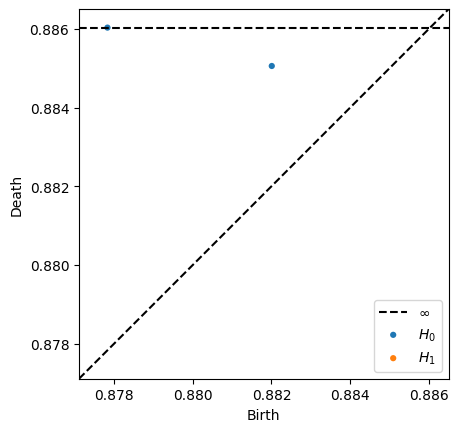

In [8]:
r = ripser(HSICmetric, distance_matrix=True, do_cocycles=True)
plot_diagrams(r['dgms'], show=True)

In [9]:
r['cocycles']

[[], []]

In [23]:
trajectories = np.array([r1_traj, r2_traj, r3_traj])
Nt, Ns, Ndim = trajectories.shape
trajectories = trajectories.reshape((Nt*Ndim, Ns))

In [24]:
nHSIC = unbiasedHSIC(trajectories)

In [27]:
np.save("./data/data_three_body/three_body_trajectory_separateCoordinates_nHSIC_Konstantin.npy", nHSIC)

In [28]:
nHSICload = np.load("./data/data_three_body/three_body_trajectory_separateCoordinates_nHSIC_Konstantin.npy")

In [29]:
nHSICload

array([[0.11109329, 0.10468334, 0.03951659, 0.02972803, 0.06518133,
        0.0633884 ],
       [0.10468334, 0.11671856, 0.05997187, 0.04586374, 0.08072205,
        0.0801745 ],
       [0.03951659, 0.05997187, 0.10879324, 0.10214015, 0.05318741,
        0.06162217],
       [0.02972803, 0.04586374, 0.10214015, 0.10741338, 0.04690765,
        0.05455374],
       [0.06518133, 0.08072205, 0.05318741, 0.04690765, 0.12485999,
        0.11986064],
       [0.0633884 , 0.0801745 , 0.06162217, 0.05455374, 0.11986064,
        0.12326507]])

In [34]:
# save as panda dataframes instead of npy files
column_keys = ['r_1', 'r_2', 'r_3']
df = pd.DataFrame(nHSIC, columns=column_keys)

In [35]:
print(df)

        r_1       r_2       r_3
0  0.117992  0.117992  0.114941
1  0.117992  0.117992  0.114941
2  0.114941  0.114941  0.122169


In [36]:
df.to_csv('./data/data_three_body/DHSIC_JointTrajectories.csv')